# 1. Local Smoothing
## An intetersting reference: https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

# A. LOWESS vs LOESS 
###   LOESS is more modern/complciated but slower, they are similar for one-dim responses, with different default tuning para. values

LOWESS stands for LOcally-Weighted Scatterplot Smoothing and is a non-parametric regression method, meaning no specifc function is specified, meaning the estimated graph does not follow a particular function. Lowess is quite powerfull to “get a feel” for data, without restricting yourself to any form. In plain terms, it is used to:

- fit a line to a scatter plot or time plot where noisy data values, sparse data points or weak interrelationships interfere with your ability to see a line of best fit.

- linear regression where least squares fitting doesn’t create a line of good fit or is too labor-intensive to use.

In [28]:
import numpy as np
import statsmodels.api as sm
np.random.seed(16)

lowess = sm.nonparametric.lowess

In [45]:
## LOWESS (this implements the method of Cleveland's 1979 JASA paper) 

x = np.linspace(1,100, 100)
y = np.random.normal(0,1,100)

z = lowess(y, x)                       ### lowess will return our "smoothed" data with a y value for at every x-value
w = lowess(y, x, frac=0.4)   ##Between 0 and 1. The fraction of the data used when estimating each y-value. Corresponds to ''span" in R.
### one important tuning parameter is "span" that controls of degree of smoothing
##    maybe choose "span" via cross-validation
w2 = lowess(y, x, frac= 1./3, it=0)

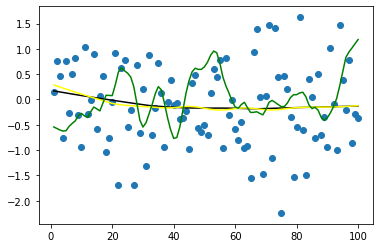

In [46]:
import matplotlib.pyplot as plt

plt.scatter(x,y)
plt.plot(z[:,0], z[:, 1], color = 'black')
plt.plot(w[:,0], w[:, 1], color = 'yellow')
plt.plot(x, Y, color = 'green')                   # loess
# plt.show()

In [48]:
## LOESS (generalization with multiple predictors)
## reference: https://towardsdatascience.com/loess-373d43b03564
import numpy as np
import time
import math


def tricubic(x):
    y = np.zeros_like(x)
    idx = (x >= -1) & (x <= 1)
    y[idx] = np.power(1.0 - np.power(np.abs(x[idx]), 3), 3)
    return y


class Loess(object):

    @staticmethod
    def normalize_array(array):
        min_val = np.min(array)
        max_val = np.max(array)
        return (array - min_val) / (max_val - min_val), min_val, max_val

    def __init__(self, xx, yy, degree=1):
        self.n_xx, self.min_xx, self.max_xx = self.normalize_array(xx)
        self.n_yy, self.min_yy, self.max_yy = self.normalize_array(yy)
        self.degree = degree

    @staticmethod
    def get_min_range(distances, window):
        min_idx = np.argmin(distances)
        n = len(distances)
        if min_idx == 0:
            return np.arange(0, window)
        if min_idx == n-1:
            return np.arange(n - window, n)

        min_range = [min_idx]
        while len(min_range) < window:
            i0 = min_range[0]
            i1 = min_range[-1]
            if i0 == 0:
                min_range.append(i1 + 1)
            elif i1 == n-1:
                min_range.insert(0, i0 - 1)
            elif distances[i0-1] < distances[i1+1]:
                min_range.insert(0, i0 - 1)
            else:
                min_range.append(i1 + 1)
        return np.array(min_range)

    @staticmethod
    def get_weights(distances, min_range):
        max_distance = np.max(distances[min_range])
        weights = tricubic(distances[min_range] / max_distance)
        return weights

    def normalize_x(self, value):
        return (value - self.min_xx) / (self.max_xx - self.min_xx)

    def denormalize_y(self, value):
        return value * (self.max_yy - self.min_yy) + self.min_yy

    def estimate(self, x, window, use_matrix=False, degree=1):
        n_x = self.normalize_x(x)
        distances = np.abs(self.n_xx - n_x)
        min_range = self.get_min_range(distances, window)
        weights = self.get_weights(distances, min_range)

        if use_matrix or degree > 1:
            wm = np.multiply(np.eye(window), weights)
            xm = np.ones((window, degree + 1))

            xp = np.array([[math.pow(n_x, p)] for p in range(degree + 1)])
            for i in range(1, degree + 1):
                xm[:, i] = np.power(self.n_xx[min_range], i)

            ym = self.n_yy[min_range]
            xmt_wm = np.transpose(xm) @ wm
            beta = np.linalg.pinv(xmt_wm @ xm) @ xmt_wm @ ym
            y = (beta @ xp)[0]
        else:
            xx = self.n_xx[min_range]
            yy = self.n_yy[min_range]
            sum_weight = np.sum(weights)
            sum_weight_x = np.dot(xx, weights)
            sum_weight_y = np.dot(yy, weights)
            sum_weight_x2 = np.dot(np.multiply(xx, xx), weights)
            sum_weight_xy = np.dot(np.multiply(xx, yy), weights)

            mean_x = sum_weight_x / sum_weight
            mean_y = sum_weight_y / sum_weight

            b = (sum_weight_xy - mean_x * mean_y * sum_weight) / \
                (sum_weight_x2 - mean_x * mean_x * sum_weight)
            a = mean_y - b * mean_x
            y = a + b * n_x
        return self.denormalize_y(y)

In [49]:
z2= Loess(x, y)
Y =[]
for xx in x:
    yy = z2.estimate(xx, window=10, use_matrix=False, degree=1)
    Y.append(yy)

# B.  kernel smoothing
###  compare a smaller (2) vs. a larger (10) bandwidth. A larger bandwith produces a smoother curve

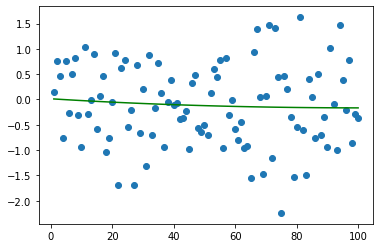

In [72]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np
import matplotlib.pyplot as plt

# The third parameter specifies the type of the variable x;
# 'c' stands for continuous
kr = KernelReg(y,x,'c',  bw='cv_ls')  #Either a user-specified bandwidth or the method for bandwidth selection. 
#If a string, valid values are ‘cv_ls’ (least-squares cross-validation) and ‘aic’ (AIC Hurvich bandwidth estimation). 
#Default is ‘cv_ls’. User specified bandwidth must have as many entries as the number of variables.

plt.scatter(x, y)
y_pred, y_std = kr.fit(x)

plt.plot(x, y_pred, 'green')
plt.show()

In [73]:
## print the bandwidth selected by CV
kr.bw   # array([62.1382197])
###A larger bandwith produces a smoother curve

array([62.1382197])

# C. splines

C:\Users\tianh\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
No handles with labels found to put in legend.


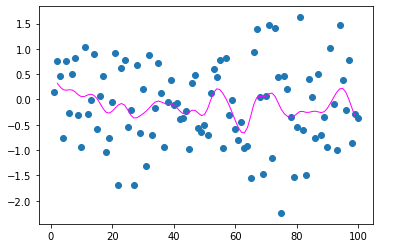

In [80]:
# from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy import ndimage

from scipy.interpolate import BSpline

# convert both to arrays
x_sm = np.array(x)
y_sm = np.array(y)

# resample to lots more points - needed for the smoothed curves
x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)

# spline - always goes through all the data points x/y
y_spline = interpolate.spline(x, y, x_smooth)

# spl = interpolate.UnivariateSpline(x, y, k = 3) #One-dimensional smoothing spline fit to a given set of data points.
# #k : Degree of the smoothing spline. Must be <= 5.

spl = BSpline(x, y, k =3)


sigma = 2
x_g1d = ndimage.gaussian_filter1d(x_sm, sigma)
y_g1d = ndimage.gaussian_filter1d(y_sm, sigma)


fig, ax = plt.subplots(figsize=(6, 4))
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

plt.scatter(x,y)
# plt.plot(x_sm, y_sm, 'green', linewidth=1)
# plt.plot(x_smooth, y_spline, 'red', linewidth=1)
# plt.plot(x_smooth, spl(x_smooth), 'yellow', linewidth=1)
plt.plot(x_g1d,y_g1d, 'magenta', linewidth=1)

plt.show()

## More choices: Savitzky–Golay filter, moving average box (by convolution), and FFT

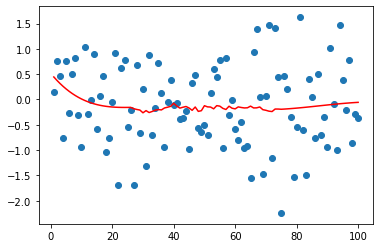

In [86]:
## We can smooth it using a Savitzky–Golay filter using the scipy.signal.savgol_filter() method:\ 
#It uses least squares to regress a small window of your data onto a polynomial, 
#then uses the polynomial to estimate the point in the center of the window. 
#Finally the window is shifted forward by one data point and the process repeats. 
#This continues until every point has been optimally adjusted relative to its neighbors. 
#It works great even with noisy samples from non-periodic and non-linear sources.

import scipy.signal
yhat = scipy.signal.savgol_filter(y, 51, 3) # window size 51, polynomial order 3

plt.scatter(x,y)
plt.plot(x,yhat, color='red')
plt.show()

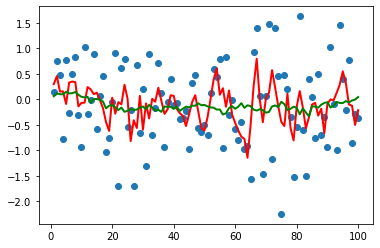

In [88]:
# A quick and dirty way to smooth data I use, based on a moving average box (by convolution):
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(x, y,'o')
plt.plot(x, smooth(y,3), 'r-', lw=2)
plt.plot(x, smooth(y,19), 'g-', lw=2)

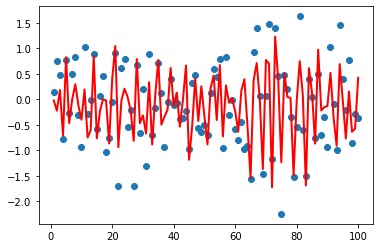

In [90]:
## If you are interested in a "smooth" version of a signal that is periodic (like your example), 
# then a FFT is the right way to go. Take the fourier transform and subtract out the low-contributing frequencies:
import scipy.fftpack

N = 100
w = scipy.fftpack.rfft(y)
f = scipy.fftpack.rfftfreq(N, x[1]-x[0])
spectrum = w**2

cutoff_idx = spectrum < (spectrum.max()/5)
w2 = w.copy()
w2[cutoff_idx] = 0

y2 = scipy.fftpack.irfft(w2)

plt.plot(x, y,'o')
plt.plot(x,y2, 'r-', lw=2)